# Preliminary code

## Importing of all required libraries.

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import minimize_scalar
from scipy.io import savemat


import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline


from typing import Callable, Tuple, List, Mapping


Function = Callable[[np.array], np.array]
Vector = List[float]
Dict = Mapping[str, float]

GRID_SIZE = 10**6

In [ ]:
def integrate(x, y, interpolate=True):
    delta = (x.max() - x.min()) / x.shape[0]
    int_values = (np.cumsum(y) - y / 2 - y[0] / 2) * delta
    if interpolate:
        return interp1d(x, int_values)
    else:
        return int_values

## Recovering the quantile function $I(p)$ from data.

First, we need to preprocess the initial data and make it convex. In order to do it, we replace $\mathrm{data}(p)$ with the convex envelope that is defined at each point of the interval $[0, 1]$ as the supremum of all convex functions that lie under that function, i.e.
$$
\mathrm{convex\_data}(p) = \sup\left\{f(x) \colon f(x) \text{ is convex and } f \le \mathrm{data} \text{ over } [0, 1]\right\}.
$$

In [ ]:
def convexify(data: Function,
              grid_size: int = GRID_SIZE) -> Function:
    """Constructs the convex envelope a given function data.

    Args:
        data: The function defined on the interval [0, 1].
        grid_size: The size of the grid.
          Default is GRID_SIZE = 10^6.

    Returns:
        The convex envelope of data.

    """
    x = np.linspace(0, 1, grid_size)
    points = np.vstack((
        x, data(x)
    ))
    points = points.T
    hull = ConvexHull(points)
    convex_data = interp1d(
        points[hull.vertices, 0],
        points[hull.vertices, 1],
        kind='linear'
    )

    return convex_data

The following function generates $\overline{w}(p) = \frac{1}{w_{sc}} \cdot \mathrm{data}(p)$ and $\overline{w}'(p)$ from preprocessed function $\mathrm{data}(p)$:

In [ ]:
def get_w_bar_from_data(data: Function, w_sc: float,
            grid_size: int = GRID_SIZE) -> Tuple[Function, Function]:
    """Constructs the couple of functions (w_bar, w_bar') from data
    and scaling coefficient.

    Args:
        data: A function defined on the interval 0 <= x <= 1
          that returns a value of preprocessed data at given point.
        w_sc: Scaling coefficient.
        grid_size: A number of points that is used to calculate
          the derivative of data numerically. Default value is SIZE = 1e6.

    Returns:
        w_bar: A function defined by the formula:
          w_bar(x) = data(1 - x) / w_sc.
        w_bar_prime: A function which is equal to the derivative of w_bar(x).

    """
    x = np.linspace(0, 1, grid_size)
    y = data(1 - x) / w_sc
    y_diff = (y[1:] - y[:-1]) * grid_size

    w_bar = interp1d(x, y, kind='linear')
    w_bar_prime = interp1d(
        np.linspace(0, 1, grid_size - 1),
        y_diff,
        kind='linear'
    )

    return w_bar, w_bar_prime

Next, generate the functions $I_{\mathrm{left}}(p)$ and $I_{\mathrm{right}}(p)$ from $\overline{w}(p)$, using the following formulas:
$$
I_{\mathrm{left}}(p) = \exp\left(\ln(\varepsilon) + \int_0^p\frac{\overline{w}'(t)}{\overline{w}(t) + 2\cdot \overline{w}(1 - 2t) - \overline{w}(0) - 2\overline{w}(1) - \varepsilon} \,dt\right)
$$

In [ ]:
def get_I_left(w_bar: Function, w_bar_prime: Function, eps: float,
               grid_size: int = GRID_SIZE) -> Function:
    """Constructs the function I_left by w_bar, w_bar_prime, and eps.

    Args:
        w_bar: The function that is equal to data(1 - x) / w_sc.
        w_bar_prime: The derivative of w_bar.
        eps: The value of I at the point 0.

        grid_size: A number of points that is used
          to integrate function numerically. Default value is GRID_SIZE = 1e6.

    Returns:
        I_left: The recovered function I(p) on the interval [0, p_low].

    """
    x = np.linspace(0, 1 / 3, grid_size)
    const = eps + w_bar(0) + 2 * w_bar(1)

    integrand = w_bar_prime(x) / (w_bar(x) + 2 * w_bar(1 - 2 * x) - const)
    log_I_left = integrate(x, integrand, interpolate=False) + np.log(eps)
    I_left = interp1d(x, np.exp(log_I_left), kind='linear')
    return I_left

And here is the formula for $I_{\mathrm{right}}(p)$:
$$
I_{\mathrm{right}}(p) = \exp\left(-2\int_0^q \frac{\overline{w}'(1 - 2t)}{\overline{w}(t) + 2\cdot \overline{w}(1 - 2t) - \overline{w}(0) - 2\overline{w}(1) - \varepsilon}\,dt\right), \quad\text{where }p = 1-2q.
$$

In [ ]:
def get_I_right(w_bar: Function, w_bar_prime: Function,
                eps: float, grid_size: int = GRID_SIZE) -> Function:
    """Constructs the function I_right by w_bar, w_bar_prime, and eps.

    Args:
        w_bar: The function that is equal to data(1 - x) / w_sc.
        w_bar_prime: The derivative of w_bar.
        eps: The value of I at the point 0.
        grid_size: A number of points that is used
          to integrate function numerically. Default value is GRID_SIZE = 1e6.

    Returns:
        I_right: The recovered function I(p) on the interval [p_up, 1]

    """
    x = np.linspace(0, 1 / 3, grid_size)
    const = eps + w_bar(0) + 2 * w_bar(1)

    integrand = (-2 * w_bar_prime(1 - 2 * x)
                 / (w_bar(x) + 2 * w_bar(1 - 2 * x) - const))
    log_I_right = integrate(x, integrand, interpolate=False)
    I_right = interp1d(1 - 2 * x, np.exp(log_I_right), kind='linear')
    return I_right

Finally, we can recover the whole function $I(p)$ using the formulas for the intervals $[0, \underline{p}]$, $[\underline{p}, \overline{p}]$, and $[\overline{p}, 1]$ as follows:
$$
I(p) = \begin{cases}
I_{\mathrm{left}}(p) &\text{if } p \in [0, \underline{p}],\\
\displaystyle I_{\mathrm{left}}(\underline{p}) \cdot \exp\left(-\frac{\overline{w}(p) - \overline{w}(\underline{p})}{C_{\mathrm{pred}}(\underline{p})}\right) &\text{if } p \in [\underline{p}, \overline{p}],\\
I_{\mathrm{right}}(p) &\text{if } p\in[\overline{p}, 1].
\end{cases}
$$

In [ ]:
def get_I(data: Function, w_sc: float, p_low: float,
          eps: float, grid_size: int = GRID_SIZE) -> Function:
    """Constructs the function I(p) from given w_bar, w_bar_prime,
    p_low, and eps.

    I(p) = I_left(p) on the interval [0, p_low],
    I(p) = exp(-(w_bar(p) - w_bar(p_low)) / C) on the interval [p_low, p_up],
        where C = I_left(p_low) * I_right(1 - 2 * p_low)^2,
    I(p) = I_right(p) on the interval [p_up, 1]

    Args:
        data: A function defined on the interval 0 <= x <= 1
          that returns a value of preprocessed data at given point.
        w_sc: Scaling coefficient.
        p_low: The parameter of the model.
        eps: The value of I(p) at p = 0.

        grid_size: The size of the grid. Default is GRID_SIZE = 10^6.

    Returns:
        I: The quantile function of recovered distribution.

    """
    w_bar, w_bar_prime = get_w_bar_from_data(data, w_sc)

    I_left = get_I_left(w_bar, w_bar_prime, eps, grid_size)
    I_right = get_I_right(w_bar, w_bar_prime, eps, grid_size)
    C = I_left(p_low) * I_right(1 - 2 * p_low) ** 2

    x = np.linspace(0, 1, grid_size)
    idx_1 = np.where(x < p_low)
    idx_2 = np.where((x >= p_low) & (x < 1 - 2 * p_low))
    idx_3 = np.where(x >= 1 - 2 * p_low)

    I_values = np.concatenate((
        I_left(x[idx_1]),
        np.exp(-(w_bar(x[idx_2]) - w_bar([p_low])) / C) * I_left(p_low),
        I_right(x[idx_3]),
    ))
    return interp1d(x, I_values, kind='linear')

## Finding optimal parameters $w_{sc}$ and $\underline{p}$

The constructed function $I(p)$ must be continuous and satisfy joint mixability condition. For fulfilling these conditions, we need to find $w_{sc}$ and $\underline{p}$ that solve the equations $\mathrm{loss}_1(\underline{p}) = \mathrm{loss}_2(\underline{p}) = 0$.

For given $\mathrm{data}(p)$ and $w_{sc}$, these functions generate $\mathrm{loss}_1(p)$ and $\mathrm{loss}_2(p)$ using the formulas:
$$
\mathrm{loss}_1(p) = \ln(I_{\mathrm{right}}(1 - 2p)) - \ln(I_{\mathrm{left}}(p)) +\frac{\overline{w}(1 - 2p) - \overline{w}(p)}{C_{\mathrm{pred}}(p)}.
$$

In [ ]:
def get_loss_1(w_bar: Function, I_left: Function, I_right: Function,
               grid_size: int = GRID_SIZE) -> Function:
    """Constructs the function loss_1 from given w_bar, I_left, and I_right.

    Args:
        w_bar: The function that is equal to data(1 - x) / w_sc.
        I_left: The recovered function I(p) on the interval [0, p_low].
        I_right: The recovered function I(p) on the interval [p_up, 1].

        grid_size: The size of the grid. Default is GRID_SIZE = 10^6.

    Returns:
        loss_1: The function that measures the discontinuity of I(p)
          at the point p = p_up.

    """
    x = np.linspace(0, 1 / 3, grid_size)
    C_pred = I_left(x) * I_right(1 - 2 * x) ** 2

    loss_1_lhs = np.log(I_right(1 - 2 * x)) - np.log(I_left(x))
    loss_1_rhs = (w_bar(1 - 2 * x) - w_bar(x)) / C_pred
    loss_1 = interp1d(x, loss_1_lhs + loss_1_rhs, kind='linear')

    return loss_1

And here is the formula for  $\mathrm{loss}_2(p)$:
$$
\mathrm{loss}_2(p) = 2\left[\ln(I_{\mathrm{right}}(1 - 2p)) - \ln(I_{\mathrm{left}}(p))\right] - \frac{3}{C_{\mathrm{pred}}(p)}\left(\overline{w}(p) -\frac{1}{1 - 3p}\int_p^{1 - 2p}\overline{w}(t)\,dt\right).
$$

In [ ]:
def get_loss_2(w_bar: Function, I_left: Function, I_right: Function,
               grid_size: int = GRID_SIZE) -> Function:
    """Constructs the function loss_2 from given w_bar, I_left, and I_right.

    Args:
        w_bar: The function that is equal to data(1 - x) / w_sc.
        I_left: The recovered function I(p) on the interval [0, p_low].
        I_right: The recovered function I(p) on the interval [p_up, 1].

        grid_size: The size of the grid. Default is GRID_SIZE = 10^6.

    Returns:
        loss_2: The function that measures the violation of
          joint mixability condition.

    """

    # In this block, we calculate the integral of w_bar(t) dt
    # on the interval [0, p] for every 0 <= p <= 1
    x = np.linspace(0, 1, grid_size)
    int_w_bar = integrate(x, w_bar(x))

    x = np.linspace(0, 1 / 3, grid_size)[:-1]
    C_pred = I_left(x) * I_right(1 - 2 * x) ** 2

    loss_2_lhs = 2 * (np.log(I_right(1 - 2 * x)) - np.log(I_left(x)))
    loss_2_rhs = 3 / C_pred * (
        w_bar(x) - 1 / (1 - 3 * x) * (int_w_bar(1 - 2 * x) - int_w_bar(x))
    )
    loss_2 = interp1d(x, loss_2_lhs - loss_2_rhs, kind='linear')

    return loss_2

For the fixed $w_{sc}$ and $\varepsilon$, we can find the optimal $\underline{p}$ that minimizes the MSE of $\mathrm{loss_1}(p)$ and $\mathrm{loss}_2(p)$, which will be denoted by $\mathrm{loss}(p)$: $\mathrm{loss}(p) = \sqrt{\mathrm{loss}_1(p)^2 + \mathrm{loss}_2(p)^2}$.

In [ ]:
def find_optimal_p_low(data: Function, w_sc: float, eps: float,
                       p_low_grid: Vector, grid_size: int = GRID_SIZE) -> Dict:
    """Returns the minimum of the function loss = sqrt(loss_1**2 + loss_2**2)
    over all p in p_low_grid.

    Args:
        data: A function defined on the interval 0 <= x <= 1
          that returns a value of preprocessed data at given point.
        w_sc: Scaling coefficient.
        eps: The value of I at the point 0.
        p_low_grid: Vector of possible values of p_low.

        grid_size: The size of the grid. Default is GRID_SIZE = 10^6.

    Returns:
        The dict with the following keys:
          'p_low': The optimal model parameter p_low from p_low_grid.

          'loss_1': The value of the function loss_1 for the optimal p_low.
          'loss_2': The value of the function loss_2 for the optimal p_low.
          'loss': The value of the function loss = sqrt(loss_1^2 + loss_2^2)
            for the optimal p_low.

    """
    w_bar, w_bar_prime = get_w_bar_from_data(data, w_sc)

    I_left = get_I_left(w_bar, w_bar_prime, eps, grid_size)
    I_right = get_I_right(w_bar, w_bar_prime, eps, grid_size)

    loss_1 = get_loss_1(w_bar, I_left, I_right, grid_size)
    loss_1_values = loss_1(p_low_grid)
    loss_2 = get_loss_2(w_bar, I_left, I_right, grid_size)
    loss_2_values = loss_2(p_low_grid)

    loss_values = np.sqrt(loss_1_values ** 2 + loss_2_values ** 2)
    optimal_idx = np.argmin(loss_values)

    return {
        'p_low': p_low_grid[optimal_idx],
        'loss_1': loss_1_values[optimal_idx],
        'loss_2': loss_2_values[optimal_idx],
        'loss': loss_values[optimal_idx],
    }

Finally, for the fixed $\varepsilon$, we find $w_{sc}$ that minimizes $\min_p \mathrm{loss}(p)$. Ideally, we need to make this minimum equal to 0: in this case, $\mathrm{loss}_1(p) = \mathrm{loss}_2(p) = 0$. The function $\min_p \mathrm{loss}(p)$ is a scalar one-variable function. We use the standard optimization routine `scipy.optimize.minimize_scalar` to find the optimal $w_{sc}$,  which is based on Brent's minimization algorithm.

In [ ]:
def find_optimal_parameters(data: Function, w_sc_bounds: Tuple[float, float],
                            eps: float, p_low_grid: Vector,
                            grid_size: int = GRID_SIZE) -> Dict:
    """Returns a couple of parameters w_sc and p_low that solves
    a system of equations loss_1(p) = 0 and loss_2(p) = 0.

    Args:
        data: A function defined on the interval 0 <= x <= 1
          that returns a value of preprocessed data at given point.
        w_sc_bounds: An interval where the optimal value for w_sc
          will be searched.
        eps: The value of I at the point 0.
        p_low_grid: Vector of possible values of p_low.

        grid_size: The size of the grid. Default is GRID_SIZE = 10^6.

    Returns:
        The dict with the following keys:
          'w_sc': The optimal scaling coefficient.
          'p_low': The optimal model parameter p_low from p_low_grid.

          'loss_1': The value of the function loss_1 for the optimal p_low.
          'loss_2': The value of the function loss_2 for the optimal p_low.
          'loss': The value of the function loss = sqrt(loss_1^2 + loss_2^2)
            for the optimal p_low.

    """
    def objective(w_sc):
        result = find_optimal_p_low(data, w_sc, eps, p_low_grid, grid_size)
        return result['loss']

    solution = minimize_scalar(objective, bounds=w_sc_bounds, method='bounded')
    if not solution['success']:
        raise ValueError(solution['message'])

    w_sc = solution['x']
    result = find_optimal_p_low(data, w_sc, eps, p_low_grid)
    result['w_sc'] = w_sc

    return result

## Construction of predicted wage function.

For a given quantile distribution function, one can construct the optimal transport plan using the rearrangement algorithm. After that, we can construct the marginal product function that is defined as follows:
$$
m(x) = y \cdot z \quad\text{if } (x, y, z) \in \mathrm{supp}(\pi).
$$
The marginal product is a correctly defined function and can be found using the following code.

In [ ]:
def get_marginal_product_func(I: Function, num_points: int) -> Function:
    """Constructs the marginal product function of a given
    quantile function I(p) using the rearrangement algorithm.

    Args:
        I: The quantile function of the distribution.
        num_points: The number of points used by
          the rearrangement algorithm.

    Returns:
        The marginal product function of a given distribution.

    """

    x = I(np.concatenate((np.random.random(num_points - 1), [1])))
    y = I(np.concatenate((np.random.random(num_points - 1), [1])))
    z = I(np.concatenate((np.random.random(num_points - 1), [1])))
    for t in range(600):
        idx = np.argsort(- y * z)
        x[idx] = np.sort(x)
        x, y, z = y, z, x
    idx = np.argsort(x)
    return interp1d(
        np.concatenate(([0], x[idx])),
        np.concatenate(([1], (y * z)[idx])),
        kind='linear'
    )

Using the marginal product function, we can find the wage function:
$$
w(t) = C - \int_0^t m(x)\,dx,
$$
where $m(x)$ is the marginal product function and $C$ is a normalization constant.

In [ ]:
def get_predicted_wages(I: Function, num_points: int = 100000,
                        grid_size: int = GRID_SIZE) -> Function:
    """Constructs the predicted wage function for
    a given marginal distribution.

    Args:
        I: The quantile function of the distribution.

        num_points: The number of points used by
          the rearrangement algorithm. Default is 10^5.
        grid_size: The size of the grid. Default is GRID_SIZE = 10^6.

    Returns:
        The predicted wage function up to the normalization constant.

    """
    marginal_prod = get_marginal_product_func(I, num_points)
    x = np.linspace(0, 1, grid_size)
    return integrate(x, -marginal_prod(x))

# Experiments with existing data

## Data extraction

First, we download existing data from Yandex.Disk.

In [ ]:
import requests

API_ENDPOINT = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={}'


def get_real_direct_link(sharing_link: str) -> str:
    pk_request = requests.get(API_ENDPOINT.format(sharing_link))
    return pk_request.json()['href']


def download_from_yandex_disk(sharing_link: str, filename: str):
    rs = requests.get(get_real_direct_link(sharing_link))
    with open(filename, 'wb') as out:
        out.write(rs.content)


download_from_yandex_disk(
    'https://disk.yandex.ru/i/eRx3Zb_dJOzwGA',
    'data.xlsx'
)

The required information is contained on the page which is called `stata_jwb`. The columns A and I represent the wages 99% of poorest people and 1% of richest people respectively in 1981. Similarly, the columns F and K represent the wages 99% of poorest people and 1% of richest people respectively in 2013. Let's extract this data.

In [ ]:
df = pd.read_excel('data.xlsx', sheet_name='stata_jwb', header=None)

data_1981_bottom = df[0].values
data_1981_top = df[8].values

data_2013_bottom = df[5].values
data_2013_top = df[10].values

In [ ]:
def connect_bottom_top_parts(bottom_data: Vector, top_data: Vector,
                             threshold: float,
                             grid_size: int = GRID_SIZE) -> Function:
    """Concatenates bottom data and top data into one smoothed function
    defined on the interval [0, 1].

    Args:
        bottom_data: Vector of data values distributed uniformly
          on the interval [0, threshold].
        top_data: Vector of data values distributed uniformly
          on the interval [threshold, 1].
        threshold: The length of the interval containing bottom_data.

    Returns:
        data: The function that is the smoothed concatenation of
          bottom_data and top_data on the interval [0, 1].
    """
    bottom_func = interp1d(
        np.linspace(0, threshold, bottom_data.shape[0]),
        bottom_data,
        kind='linear',
    )
    top_func = interp1d(
        np.linspace(threshold, 1, top_data.shape[0]),
        top_data,
        kind='linear',
    )

    x = np.linspace(0, 1, grid_size)
    data_func = interp1d(
        x,
        np.concatenate((
            bottom_func(x[np.where(x < threshold)]),
            top_func(x[np.where(x > threshold)]),
        )),
        kind='linear'
    )

    return data_func

## Results for the year 1981

Find optimal parameters $w_{sc}$ and $\underline{p}$ for the year 1981.

In [ ]:
data_1981 = connect_bottom_top_parts(
    data_1981_bottom, data_1981_top,
    threshold=0.99
)
convex_data_1981 = convexify(data_1981)

eps = 5e-3
w_sc_bounds = (1e4, 1e7)
p_low_grid = np.linspace(0.01, 0.2, GRID_SIZE)

params = find_optimal_parameters(
    convex_data_1981, w_sc_bounds, eps, p_low_grid
)

for key in params:
    print(f'{key}: {params[key]}')

p_low: 0.052853592853592854
loss_1: -8.17894661277468e-09
loss_2: -1.2530569959078763e-08
loss: 1.4963634290973086e-08
w_sc: 1020544.3901413217


Plot the quantile function $I(p)$ and $\ln(I(p)$.

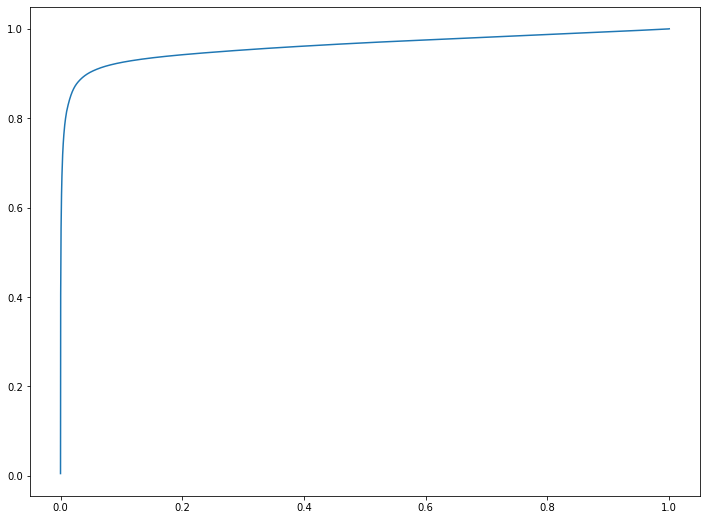

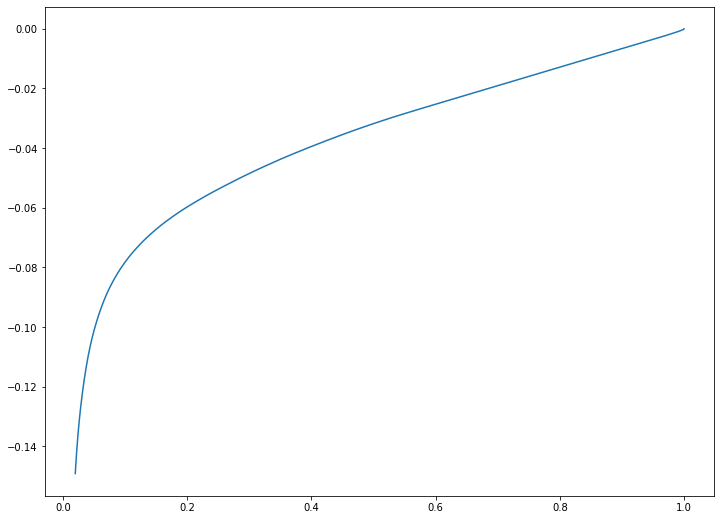

In [ ]:
p_low_1981 = params['p_low']
w_sc_1981 = params['w_sc']

I_1981 = get_I(convex_data_1981, w_sc_1981, p_low_1981, eps)

fig = plt.figure(figsize=(12, 9))
x = np.linspace(0, 1, GRID_SIZE)
plt.plot(x, I_1981(x))
plt.show()

fig = plt.figure(figsize=(12, 9))
x = np.linspace(0.02, 1, GRID_SIZE)
plt.plot(x, np.log(I_1981(x)))
plt.show()

Compare the predicted wage function with the initial data.



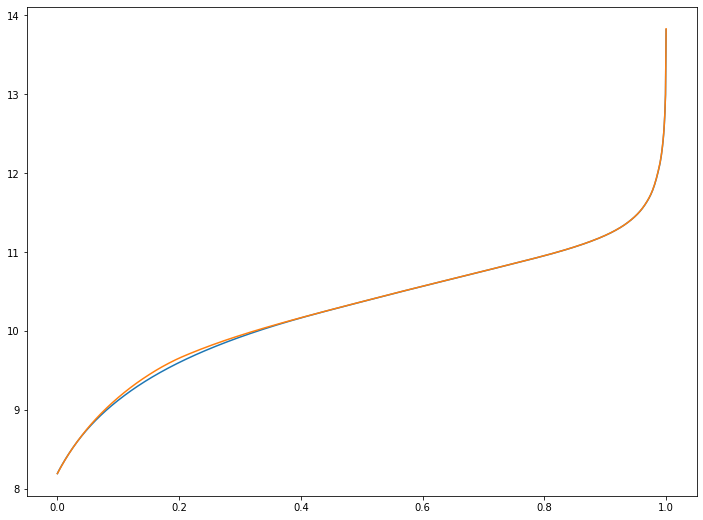

In [ ]:
wage = get_predicted_wages(I_1981)
const = data_1981(0) - w_sc_1981 * wage(1)

fig = plt.figure(figsize=(12, 9))
x = np.linspace(0, 1, 1000)
plt.plot(x, np.log(const + w_sc_1981 * wage(I_1981(1 - x))))
plt.plot(x, np.log(data_1981(x)))
plt.show()

Save the model into the matlab-compatible file.

In [ ]:
x = np.linspace(0, 1, 10000)
savemat('model_1981.mat', {
    'I_1981': I_1981(x),
    'w_sc_1981': [w_sc_1981],
    'p_low_1981': [p_low_1981],
})

## Results for the year 2013

Find optimal parameters $w_{sc}$ and $\underline{p}$ for the year 2013.

In [ ]:
data_2013 = connect_bottom_top_parts(
    data_2013_bottom, data_2013_top,
    threshold=0.99
)
convex_data_2013 = convexify(data_2013)

eps = 5e-3
w_sc_bounds = (1e4, 1e7)
p_low_grid = np.linspace(0.01, 0.2, GRID_SIZE)

params = find_optimal_parameters(
    convex_data_2013, w_sc_bounds, eps, p_low_grid
)

for key in params:
    print(f'{key}: {params[key]}')

p_low: 0.10163405163405163
loss_1: 2.775531171554621e-09
loss_2: -5.2691516908445295e-09
loss: 5.955462435898755e-09
w_sc: 4113570.935976762


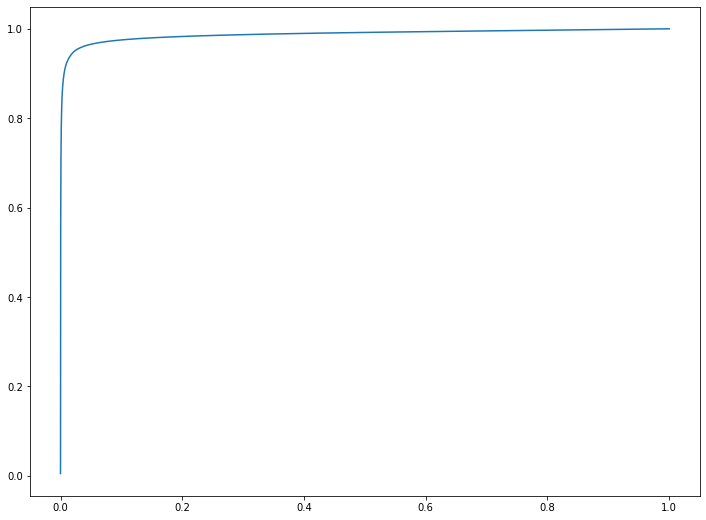

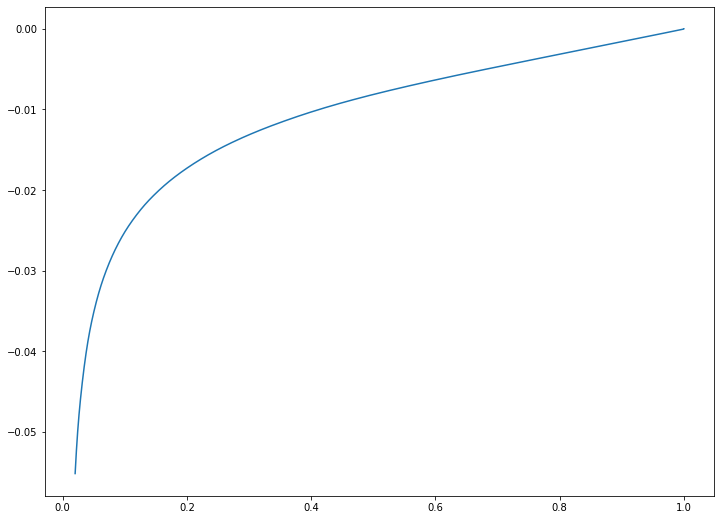

In [ ]:
p_low_2013 = params['p_low']
w_sc_2013 = params['w_sc']

I_2013 = get_I(convex_data_2013, w_sc_2013, p_low_2013, eps)

fig = plt.figure(figsize=(12, 9))
x = np.linspace(0, 1, GRID_SIZE)
plt.plot(x, I_2013(x))
plt.show()

fig = plt.figure(figsize=(12, 9))
x = np.linspace(0.02, 1, GRID_SIZE)
plt.plot(x, np.log(I_2013(x)))
plt.show()

Compare the predicted wage function with the initial data.

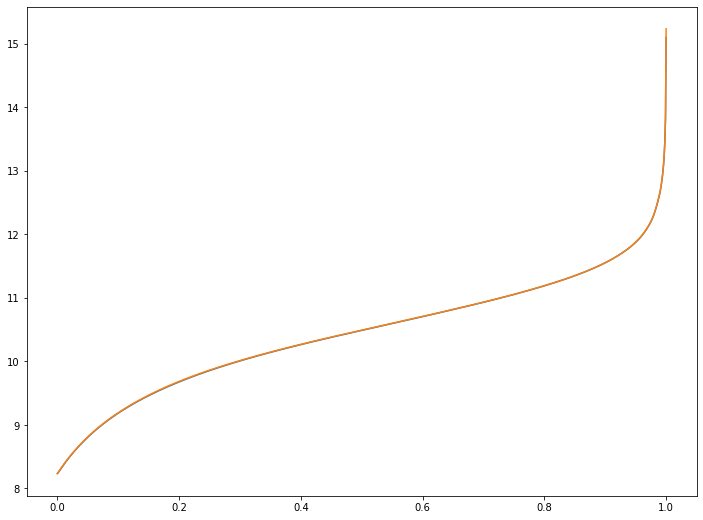

In [ ]:
wage = get_predicted_wages(I_2013)
const = data_2013(0) - w_sc_2013 * wage(1)

fig = plt.figure(figsize=(12, 9))
x = np.linspace(0, 1, 1000)
plt.plot(x, np.log(const + w_sc_2013 * wage(I_2013(1 - x))))
plt.plot(x, np.log(data_2013(x)))
plt.show()

In [ ]:
x = np.linspace(0, 1, 10000)
savemat('model_2013.mat', {
    'I_2013': I_2013(x),
    'w_sc_2013': [w_sc_2013],
    'p_low_2013': [p_low_2013],
})

# The part to remove

In [ ]:
from scipy.spatial import ConvexHull

data_1981_top = interp1d(
    np.linspace(0.99, 1, 100),
    df[8].values,
    kind='cubic'
)
data_1981_bottom = interp1d(
    np.linspace(0, 0.99, 100),
    df[0].values,
    kind='cubic'
)
x = np.linspace(0, 1, 100000)
data_1981 = interp1d(
    x,
    np.concatenate((
        data_1981_bottom(x[:-1000]),
        data_1981_top(x[-1000:]),
    )),
    kind='cubic'
)
data_2013_top = interp1d(
    np.linspace(0, 0.01, 100),
    df[10].values[::-1],
    kind='cubic'
)
data_2013_bottom = interp1d(
    np.linspace(0.01, 1, 100),
    df[5].values[::-1],
    kind='cubic'
)
x = np.linspace(0, 1, 100000)
data_2013 = interp1d(
    x,
    np.concatenate((
        data_2013_top(x[:1000]),
        data_2013_bottom(x[1000:]),
    )),
    kind='cubic'
)

md_1981 = convexify(data_1981)
md_2013 = convexify(data_2013)

In [ ]:
GRID_SIZE = 1000000





















def optimize_w_sc(data: Function, eps: float, w_sc_bounds: Tuple[float, float],
                  w_sc_grid_size: int, num_iter: int) -> Dict:
    l, r = w_sc_bounds
    for step in range(num_iter):
        w_sc_grid = np.geomspace(l, r, w_sc_grid_size)

        result = None
        optimal_idx = None

        progress_bar = tqdm(
            enumerate(w_sc_grid),
            total=w_sc_grid_size,
            desc=f'Step {step + 1}',
            position=0,
        )

        for idx, w_sc in progress_bar:
            current_res = find_optimal_p_low(data, w_sc, eps)
            if result is None or current_res['loss'] < result['loss']:
                result = current_res
                result['w_sc'] = w_sc
                optimal_idx = idx

        left_idx = max(0, optimal_idx - 2)
        right_idx = min(optimal_idx + 2, w_sc_grid_size)
        l = w_sc_grid[left_idx]
        r = w_sc_grid[right_idx]

    return result






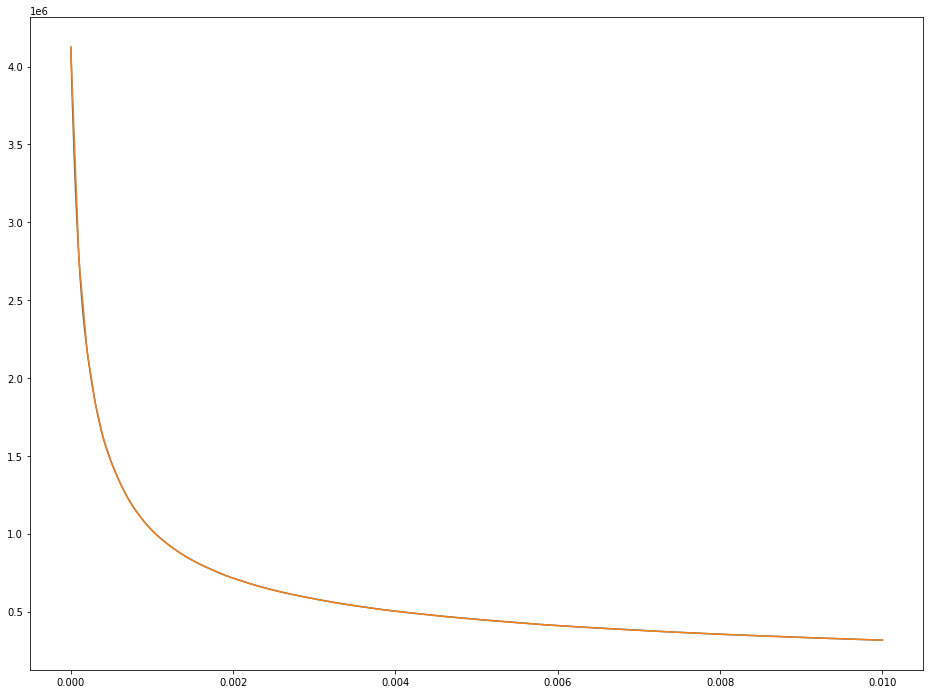

In [ ]:
fig = plt.figure(figsize=(16, 12))
x = np.linspace(0, 0.01, 10000)
plt.plot(x, data_2013(x))
x = np.concatenate((np.linspace(0, 0.01, 100), ))
y = np.concatenate((df[10].values[::-1],))
plt.plot(x, y)
plt.show()

In [ ]:
w_sc

1011208.8544135572

Step 6: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


{'p_low': 0.0522946122946123, 'loss_1': 4.2921664915976e-05, 'loss_2': -3.885717998279022e-06, 'loss': 4.309719391702289e-05, 'w_sc': 1011262.3045389239}


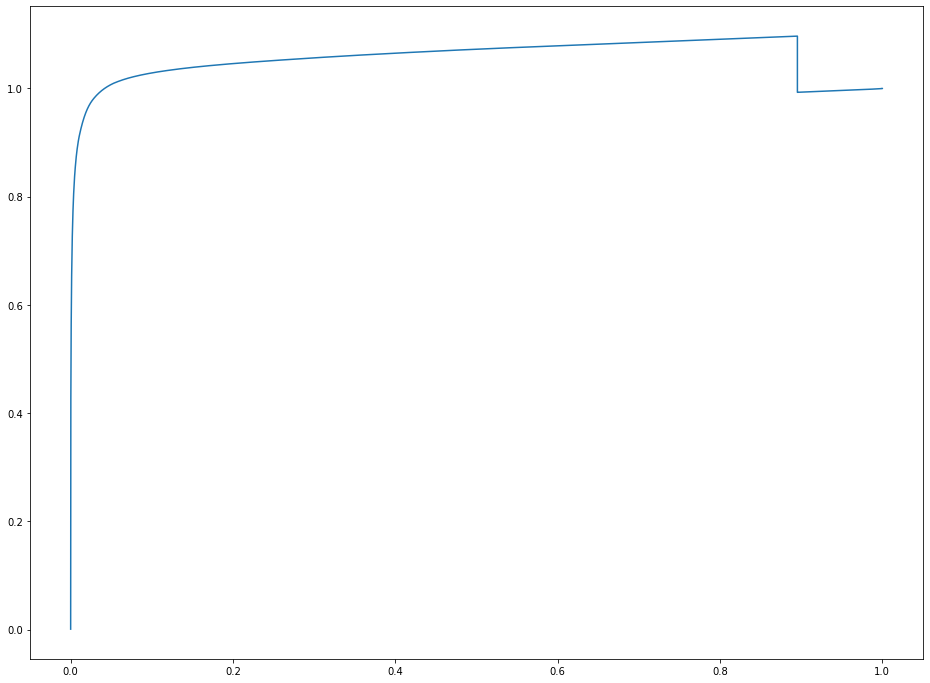

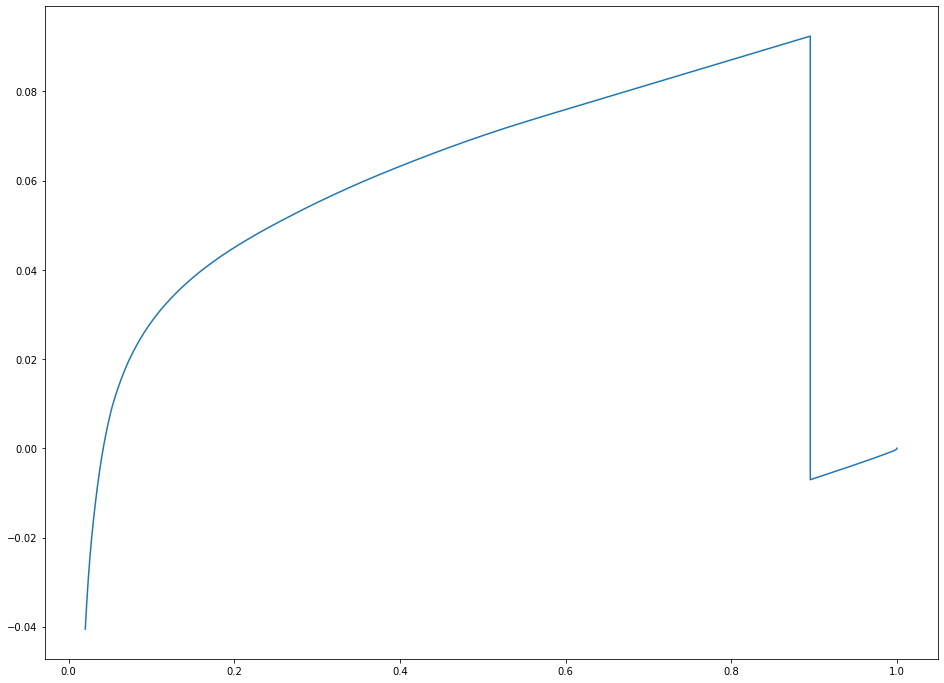

In [ ]:
# 1981 year

w_sc_bounds = (3e4, 1e7)
p_low_grid = np.linspace(0.01, 0.2, 100000)

result = optimize_w_sc(
    md_1981, eps=5e-3, w_sc_bounds=w_sc_bounds,
    w_sc_grid_size=20, num_iter=6
)

w_sc_1981 = result['w_sc']
p_low_1981 = result['p_low']
print(result)

w_bar, w_bar_prime = get_w_bar_from_data(md_1981, w_sc_1981)
I_1981 = get_I(w_bar, w_bar_prime, p_low_1981, eps)

fig = plt.figure(figsize=(16, 12))
x = np.linspace(0, 1, SIZE)
plt.plot(x, I_1981(x))
plt.show()

fig = plt.figure(figsize=(16, 12))
x = np.linspace(0.02, 1, SIZE)
plt.plot(x, np.log(I_1981(x)))
plt.show()

In [ ]:
sorted_result = result.sort_values(by='loss')

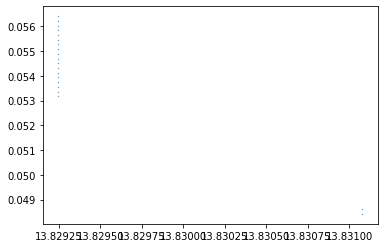

In [ ]:
scale = sorted_result.iloc[np.where(sorted_result['loss'] < 1e-3)]['scale']
p_low = sorted_result.iloc[np.where(sorted_result['loss'] < 1e-3)]['p_low']

plt.scatter(np.log(scale), p_low, s=0.1)

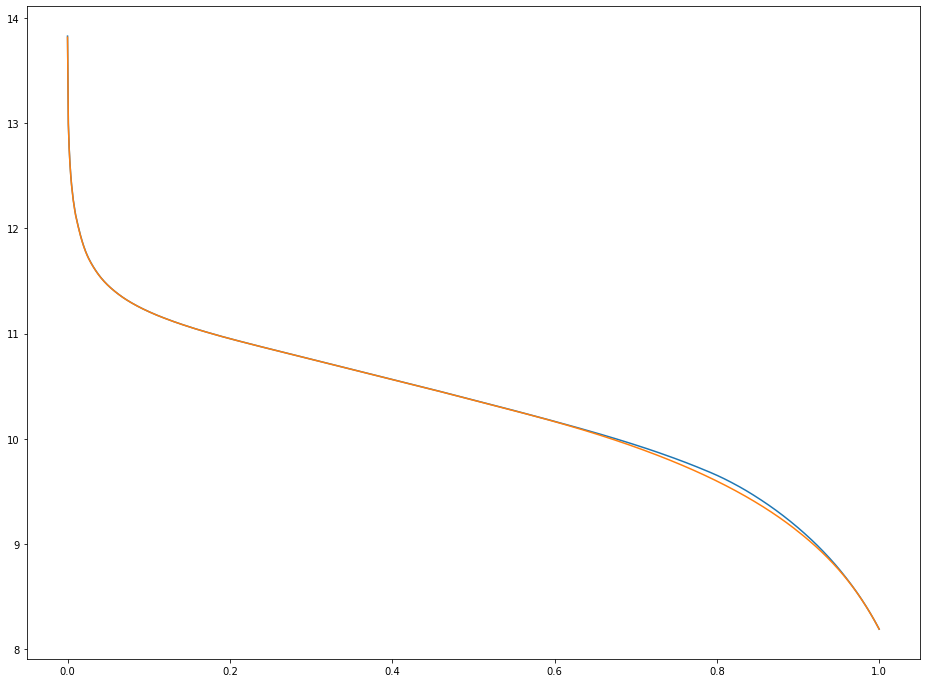

In [ ]:
lambda_1981 = find_approximate_lambda(I_1981)
x = np.linspace(0, 1, SIZE)
w_1981 = integrate(x, lambda_1981(x), interpolate=False) * scale_1981
pred_w_1981 = interp1d(x, w_1981 + data_1981([1]) - w_1981[-1], kind='linear')

fig = plt.figure(figsize=(16, 12))
x = np.linspace(0, 1, 1000)
plt.plot(x, np.log(data_1981(x)))
plt.plot(x, np.log(pred_w_1981(I_1981(x))))
plt.show()

200it [01:20,  2.47it/s]


scale     4.117485e+06
p_low     1.014751e-01
eps       5.000000e-03
loss_1    4.711774e-06
loss_2   -2.374759e-07
loss      4.717754e-06
Name: 1494814, dtype: float64


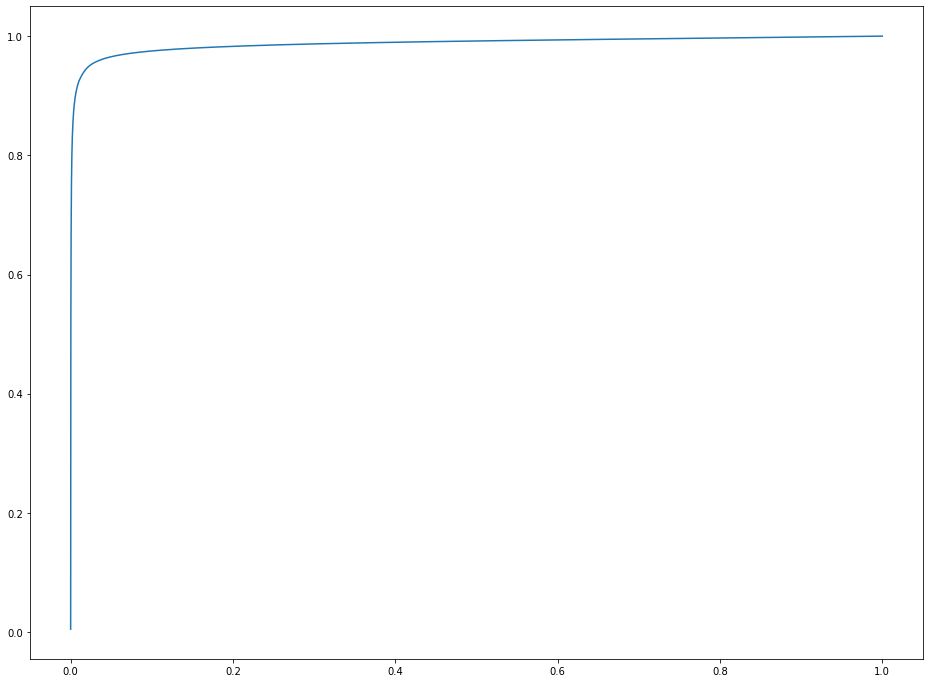

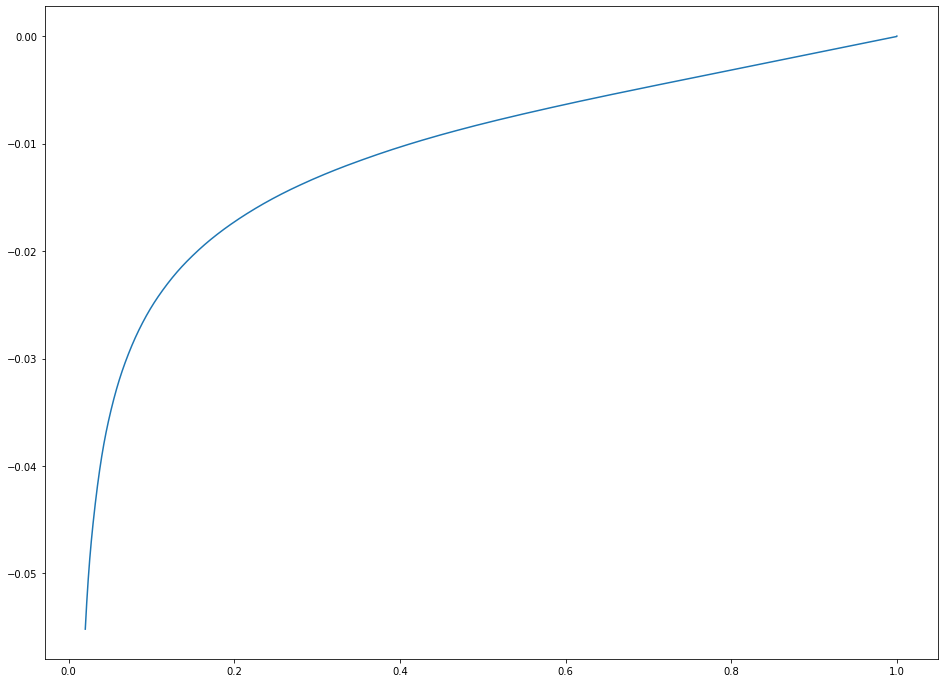

In [ ]:
# 2013 year

scale_space = np.geomspace(4.11e6, 4.12e6, 200)
eps_space = [5e-3]
p_space = np.linspace(0.01, 0.2, 10000)

result = pd.DataFrame.from_dict(
    grid_search(md_2013, scale_space, p_space, eps_space)
)
min_loss_col = result.iloc[result['loss'].idxmin()]
scale_2013 = min_loss_col['scale']
p_low_2013 = min_loss_col['p_low']
eps = min_loss_col['eps']
print(min_loss_col)

f, f_prime = generate_f(md_2013, scale_2013)
I_2013 = find_I(f, f_prime, p_low_2013, eps)

fig = plt.figure(figsize=(16, 12))
x = np.linspace(0, 1, SIZE)
plt.plot(x, I_2013(x))
plt.show()

fig = plt.figure(figsize=(16, 12))
x = np.linspace(0.02, 1, SIZE)
plt.plot(x, np.log(I_2013(x)))
plt.show()

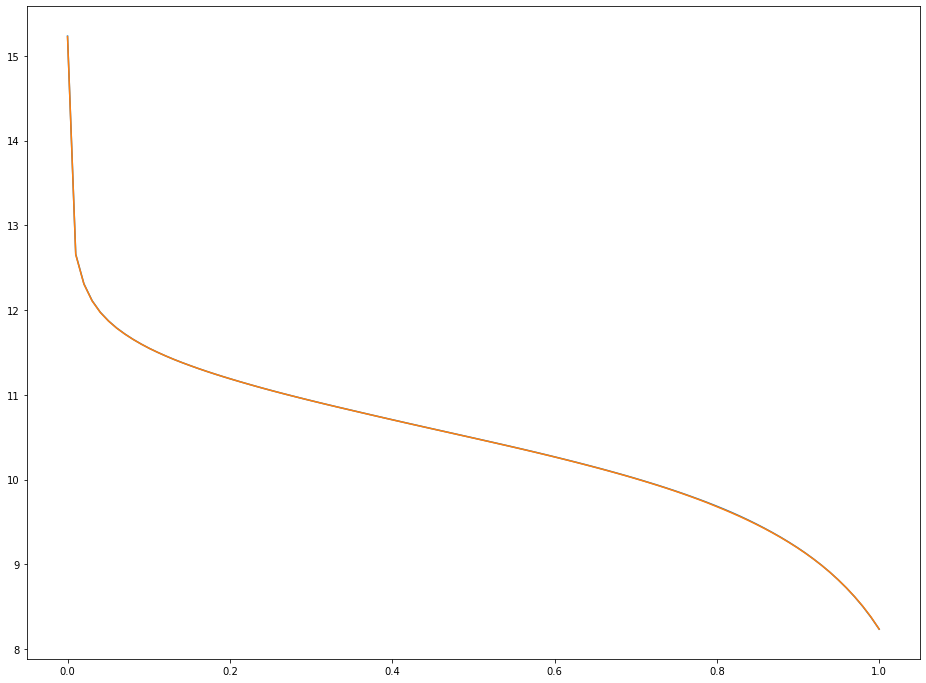

In [ ]:
lambda_2013 = find_approximate_lambda(I_2013)
x = np.linspace(0, 1, SIZE)
w_2013 = integrate(x, lambda_2013(x), interpolate=False) * scale_2013
pred_w_2013 = interp1d(x, w_2013 + data_2013([1]) - w_2013[-1], kind='linear')

fig = plt.figure(figsize=(16, 12))
x = np.linspace(0, 1, 100)
plt.plot(x, np.log(data_2013(x)))
plt.plot(x, np.log(pred_w_2013(I_2013(x))))
plt.show()

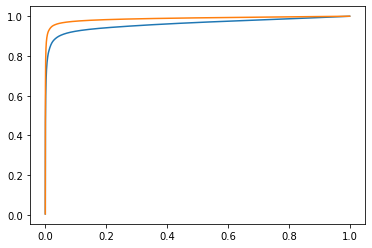

In [ ]:
x = np.linspace(0, 1, SIZE)
plt.plot(x, I_1981(x))
plt.plot(x, I_2013(x))
plt.show()

In [ ]:
from scipy.io import savemat

x = np.linspace(0, 1, 10000)
savemat('export.mat', {
    'I_1981': I_1981(x),
    'I_2013': I_2013(x),
    'scale_1981': [scale_1981],
    'scale_2013': [scale_2013],
})

In [ ]:
f, f_prime = generate_f(modified_data, scale)
I = find_I(f, f_prime, p_low, eps)
px.line(x=np.linspace(0.01, 1, 10000), y=I(np.linspace(0.01, 1, 10000)))